# 내가 직접 해보는 케글 
- 참고자료 : https://jamm-notnull.tistory.com/16

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

## 데이터 불러오기

In [3]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 날짜 변환
- date컬럼에 필요없는 부분이 많이 있음(시간 부분)
- 이걸 떼버리고 사용하려고 함

In [4]:
train["date"] = train.date.str[:6].astype(int)
train

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,201410,610685.0,4,2.50,2520,6023,2.0,0,0,...,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,15031,201503,1007500.0,4,3.50,3510,7200,2.0,0,0,...,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,15032,201405,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,15033,201502,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


### 타겟변수 따로 저장하기

In [5]:
train.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [6]:
y = train["price"]
del train["price"]

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [7]:
del train["id"]

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


## 테스트 데이터에 대해서도 똑같이 적용

In [8]:
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [9]:
# 날짜 변환
test["date"] = test["date"].str[:6].astype(int)
test

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,21498,201406,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,21499,201501,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,21500,201502,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,21501,201406,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007


In [10]:
# test데이터 id삭제하기
test_id_sub = test["id"]  # 삭제하기 전에 id를 따로 저장해놓자
del test["id"]

In [11]:
test

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,201406,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,201501,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,201502,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,201406,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007


In [12]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

## 데이터 확인

__seborn으로 y값 분포 확인__

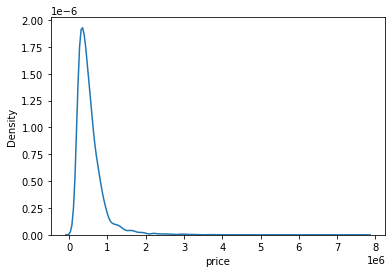

In [13]:
# kde 그래프로 분포 확인
sns.kdeplot(y)
plt.show()

__정규화__
- y값의 분포가 너무 치우쳐 있어 이를 정규분포 모양으로 만들어줄 필요가 있음
- np.log1p함수로 로그화 시켜준다음에 np.expm1으로 다시 원래대로 변환

> np.log1p 공식문서 ; https://numpy.org/doc/stable/reference/generated/numpy.log1p.html
np.expm1 공식문서 : https://numpy.org/doc/stable/reference/generated/numpy.expm1.html

In [14]:
y_log = np.log1p(y)
y_log

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

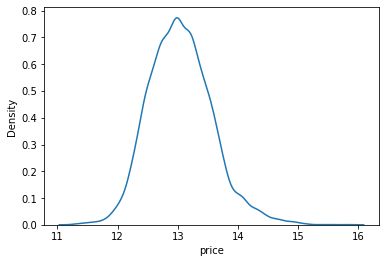

In [15]:
sns.kdeplot(y_log)
plt.show()

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

## 다양한 실험을 위해 함수로 만들어 쓰자
- 머신러닝 모델을 학습시키고 튜닝하기 위해서는 다양항 모델로 실험을 해봐야함

__RMSE 계산__

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

- 대회 평가 방식이 RMSE를 기준으로 하는 만큼 RMSE를 빠르게 구해줄 도구가 필요함
- 다만 우리가 예측하는 y값은 log가 씌워져 있으므로 exp를 자동으로 해서 구해주는 함수가 있으면 편할수 있음

In [18]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

__모델 불러오기__
- 다음으로 XGBRegressor, LGBMRegressor, GradientBoostingRegressor, RandomForestRegressor 네 가지 모델을 가져오겠습니다.

In [19]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [20]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [21]:
# 각 모델의 이름은 이렇게 확인할 수 있다 
gboost.__class__.__name__

'GradientBoostingRegressor'

In [22]:
train

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,201503,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,201405,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,201502,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [23]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__
    
    # train, test 데이터셋 분리 - 여기에도 random_states를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                       y_log,
                                                       random_state = random_state,
                                                       test_size = 0.2)
    
    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)
    
    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index = ["RMSE"]).T.sort_values("RMSE", ascending = False)
    
df

{'GradientBoostingRegressor': 128360.19649691365,
 'XGBRegressor': 110318.66956616656,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125487.07102453562}

In [24]:
y_pred

array([13.25081727, 12.09179797, 12.58323849, ..., 13.26490029,
       12.37154465, 13.19160358])

In [25]:
def get_scores(models, train, y):
    df = {}

    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # train, test 데이터셋 분리 - 여기에도 random_states를 고정합니다. 
        X_train, X_test, y_train, y_test = train_test_split(train,
                                                            y,
                                                            random_state = random_state,
                                                            test_size = 0.2)

        # 모델 학습
        model.fit(X_train, y_train)

        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)

        # data frame에 저장
        score_df = pd.DataFrame(df, index = ["RMSE"]).T.sort_values("RMSE", ascending = False)
    return score_df

In [26]:
get_scores(models, train, y_log)

,RMSE
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125487.071025
LGBMRegressor,111920.367359
XGBRegressor,110318.669566


## 하이퍼 파라미터 튜닝의 최강자, 그리드 탐색

- 실험은 sklearn.model_selection 라이브러리 안에 있는 GridSearchCV 클래스를 활용합니다. 

__GridSearchCV 란 무엇일까?__
1. 그리드 탐색과 랜덤 탐색의 차이
    - *랜덤탐색*은 사람이 탐색할 하이퍼 파라미터의 공간만 정해두고, 그 안에서 랜덤으로 조합을 선택해서 탐색하는 방법
    - *그리드탐색*은 사람이 정해둔 값들로 이루어지는 조합만 탐색하기 떄문에 최적의 조합을 놓칠 수 있음
    - 랜덤탐색에서는 말 그대로 랜덤으로 탐색하기 떄문에 최적의 조합을 찾을 수 있는 가능성이 언제나 열려 있음. 하지만 그 가능성 또한 랜덤성에 의존하기 떄문에 언제나 최적을 찾는다는 보장은 없음
    
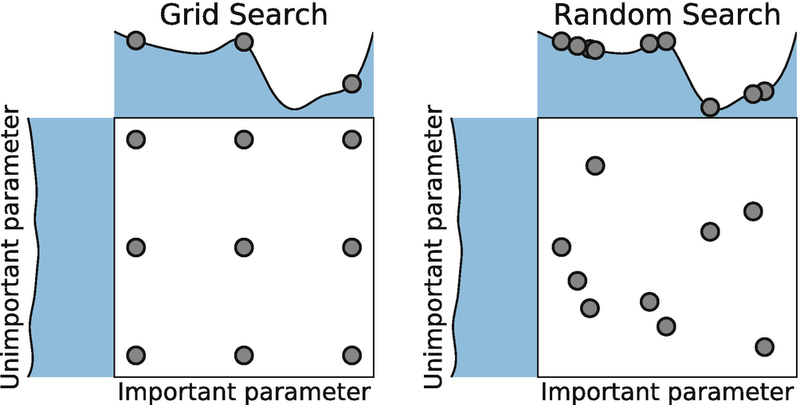


2. GridSearchCV 입력되는 인자
    - param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
    - scoring : 모델의 성능을 평가할 지표
    - cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
    - verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
    - n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수

In [27]:
from sklearn.model_selection import GridSearchCV

In [28]:
# xgboost 관련 하이퍼 파라미터
param_grid = {
    'n_estimators' : [50, 100],
    'max_depth' : [1,10],
}

In [29]:
model = LGBMRegressor(random_state = random_state)

In [30]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y_log)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

__Q. 출력된 메세지에 나타난 "totalling 20 fit"에서 20은 어떻게 계산된 값일까요?__

>내가 입력한 파라미터는 2가지 종류에 각각 2가지씩 넣었으므로 가능한 조합은 2x2 = 4 가지 이다.  
또한 cross Validation은 각 경우마다 5번을 진행하믕로 총 4x5 = 20번의 fits를 진행하게 된다.  
5번을 진행해서 평균을 취하는 것이 일반화 오차를 추정하는 데에 더 신뢰도가 높기 때문이다.   
간단하게, 한 번만 해 보는 것보다는 다섯 번을 해보고 구한 평균값이 더 정확하다. 

In [31]:
# 실험에 대한 결과
grid_model.cv_results_

{'mean_fit_time': array([0.41463971, 0.56658649, 1.11766882, 1.54480467]),
 'std_fit_time': array([0.05657013, 0.08672273, 0.09690416, 0.07430001]),
 'mean_score_time': array([0.02551804, 0.04614797, 0.06527224, 0.09307194]),
 'std_score_time': array([0.01105998, 0.0196105 , 0.02467017, 0.02725035]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': array([-0.07354904

In [32]:
# 정보가 너무 많아서 필요한 정보만 추출하자
params = grid_model.cv_results_["params"]
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [33]:
score = grid_model.cv_results_["mean_test_score"]
score

array([-0.07339447, -0.05502043, -0.02917734, -0.02702714])

In [34]:
for i, j in zip(params, score):
    print(f"{i} : {j}")

{'max_depth': 1, 'n_estimators': 50} : -0.07339447204407863
{'max_depth': 1, 'n_estimators': 100} : -0.055020428127870044
{'max_depth': 10, 'n_estimators': 50} : -0.0291773402617981
{'max_depth': 10, 'n_estimators': 100} : -0.027027144840492612


In [35]:
params_score = pd.DataFrame(params)
params_score["score"] = score
params_score

,max_depth,n_estimators,score
0,1,50,-0.073394
1,1,100,-0.055020
2,10,50,-0.029177
3,10,100,-0.027027


__Q. 아래 페이지에서는 각 scoring을 세 가지로 분류해놓고 있다. 세 분류의 범주는?__
- 링크 : https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter  
Classification, Clustering, Regression

In [36]:
params_score["RMSE"] = np.sqrt(-score)
params_score

,max_depth,n_estimators,score,RMSE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


### RMSE : RMSLE
- 지금 구한 RMSE는 앞서 로그값을 취한 값에 대한 RMSE이다. 
- 아직 이를 변환해준 과정이 없었으므로 이름을 "RMSLE"로 바꿔주도록 하겠다. 
- pandas에서는 rename으로 컬럼명을 바꿀 수 있다. 

In [37]:
params_score = params_score.rename(columns = {"RMSE":"RMSLE"})
params_score

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [38]:
# RMSLE가 낮은 순으로 정렬해주세요
params_score.sort_values(by="RMSLE", ascending = False, inplace = True)
params_score

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [39]:
"""
다음과 같은 과정을 진행할 수 있는 
`my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 
함수를 구현해 보세요.

1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다. 
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
"""

def my_GridSearch(model, train, y, param_grid, verbose = 2, n_jobs = 5):
    # 1. GridSearchCV 모델로 'model'을 초기화합니다. 
    grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring = 'neg_mean_squared_error', \
                        cv = 5, verbose = verbose, n_jobs = n_jobs)
    
    # 모델을 fitting 합니다.
    grid_model.fit(train, y)
    
    # params, score에 각 조합에 대한 결과를 저장합니다. 
    params = grid_model.cv_results_["params"]
    score = grid_model.cv_results_["mean_test_score"]
    
    # 데이터 프레임을 생성하고,  
    params_score = pd.DataFrame(params)
    params_score["score"] = score
    
    # RMSLE 값을 추가한 후 점수가 높은 순서로 정렬하고 값을 반환한다.
    params_score["RMSLE"] = np.sqrt(-score)
    params_score.sort_values(by="RMSLE", ascending = False, inplace = True)
    
    return params_score


In [40]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y_log, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


- max_depth = 10, n_estimators = 100 이 가장 좋은 조합
- 해당 하이퍼 파라미터로 예측값인 submission.csv. 파일을 만들어 제출해보겠습니다. 

In [41]:
# 하이퍼 파라미터 10, 100 입력
model = LGBMRegressor(max_depth = 10, n_estimators = 100, random_state = random_state)

# 학습
model.fit(train, y_log)  

# 학습된 모델을 통해 예측
prediction = model.predict(test)
prediction

array([13.13580793, 13.08051399, 14.11202067, ..., 13.01592878,
       12.69894979, 12.96297768])

In [42]:
# 예측결과 지수화 해서 출력
prediction = np.expm1(prediction)
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

- 위에서 했던 대로 sample_submission.csv 파일을 가져와보겠습니다.

In [43]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [44]:
submission["price"] = prediction
submission

,id,price
0,15035,5.067667e+05
1,15036,4.795061e+05
2,15037,1.345155e+06
3,15038,3.122579e+05
4,15039,3.338645e+05
...,...,...
6463,21498,2.328743e+05
6464,21499,4.038553e+05
6465,21500,4.495159e+05
6466,21501,3.274029e+05


In [45]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index = False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv


__함수로 정의__

In [46]:
"""
아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수를 구현해 주세요.
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""

def save_submission(model, train, y, test, model_name, rmsle = None):
    # 모델을 train, y로 학습
    model.fit(train, y)
    
    # test에 대해 예측
    prediction = model.predict(test)
    
    # 예측값을 np.exp,1로 변환
    prediction = np.expm1(prediction)
    
    # 데이터프레임으로 변환
    df = pd.DataFrame(test_id_sub)
    df["price"] = prediction
    df.reset_index(drop =True)
    
    # submossion_model_name_RMSLE_100000.csv 로 저장
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_csv_path = f'{data_dir}/submossion_{model_name}_RMSLE_{rmsle}.csv'
    submission.to_csv(submission_csv_path, index = False)
    
    print(f"{submission_csv_path}Success Save!")

In [47]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

/aiffel/aiffel/kaggle_kakr_housing/data/submossion_lgbm_RMSLE_0.0168.csvSuccess Save!
